In [1]:
!pip install fastf1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1


In [2]:
# Importing all libaries
import fastf1
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [3]:
# Creating the cache folder if it doesn't exist
if not os.path.exists('./f1_cache'):
    os.makedirs('./f1_cache')

# Enabling cache for FastF1
fastf1.Cache.enable_cache('./f1_cache')

In [4]:
# Load 2024 Bahrain GP race session, lap and sector times
print("Loading 2024 Bahrain GP data...")
session = fastf1.get_session(2024, 'Bahrain Grand Prix', 'R')
session.load()
laps = session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time", "Compound"]].dropna()

Loading 2024 Bahrain GP data...


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

In [5]:
# Converting time columns to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps[f"{col}_seconds"] = laps[col].dt.total_seconds()

In [6]:
# Grouping by driver to get average sector time per driver
sector_avg = laps.groupby("Driver")[["Sector1Time_seconds", "Sector2Time_seconds", "Sector3Time_seconds"]].mean().reset_index()

In [7]:
# Average lap time per driver
avg_laptime = laps.groupby("Driver")["LapTime_seconds"].mean().reset_index()

In [8]:
# average tire age for each driver(Degradation Feature)
laps["TireAge"] = laps.groupby(["Driver", "Compound"]).cumcount() + 1
tire_age = laps.groupby("Driver")["TireAge"].mean().reset_index()

In [9]:
# Using actual historical race positions as a key feature
race_results = pd.DataFrame({
    "Driver": ["VER", "PER", "SAI", "HAM", "RUS", "LEC", "NOR", "PIA", "ALO", "STR",
               "HUL", "TSU", "ALB", "RIC", "MAG", "OCO", "GAS", "BOT", "ZHO", "SAR"],
    "RacePosition2024": list(range(1, 21))  # Positions 1-20
})

In [10]:
# Get fastest lap per driver as another performance indicator
fastest_laps = laps.groupby("Driver")["LapTime_seconds"].min().reset_index()
fastest_laps.rename(columns={"LapTime_seconds": "FastestLap_seconds"}, inplace=True)

In [11]:
# Qualifying Times for 2025 Bahrain GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["PIA", "RUS", "LEC", "ANT", "GAS", "NOR", "VER", "SAI", "HAM", "TSU",
               "DOO", "HAD", "ALO", "OCO", "ALB", "HUL", "LAW", "BOR", "STR", "BEA"],
    "QualifyingTime_seconds": [
        89.841, 90.009, 90.175, 90.213, 90.216, 90.267, 90.423, 90.680, 90.772, 91.303,
        91.414, 91.591, 91.634, 91.594, 92.040, 92.067, 92.165, 92.186, 92.283, 92.373
    ],
    "QualifyingPosition": list(range(1, 21))  # Positions 1-20
})


In [12]:
#a more meaningful target variable based on both qualifying position and 2024 race result
# First we merge with 2024 race results where available
modeling_data = qualifying_2025.merge(race_results, on="Driver", how="left")

In [13]:
# Fill NA for drivers who didn't race in 2024
modeling_data["RacePosition2024"] = modeling_data["RacePosition2024"].fillna(15)

In [14]:
# Creating win probability based on qualifying position (higher weight) and previous race results
# These coefficients determine how much each factor matters
qualifying_weight = 0.7
previous_race_weight = 0.3

In [15]:
# Calculating win probability score
modeling_data["WinScore"] = (
    qualifying_weight * (21 - modeling_data["QualifyingPosition"]) +
    previous_race_weight * (21 - modeling_data["RacePosition2024"])
) / 20  # Normalize to 0-1 range


In [51]:
# Defining top contenders based on combined factors
modeling_data["ChanceToWin"] = (modeling_data["WinScore"] >= 0.8).astype(int)

print("\nTarget variable distribution:")
print(modeling_data["ChanceToWin"].value_counts())


Target variable distribution:
ChanceToWin
0    17
1     3
Name: count, dtype: int64


In [53]:
# Add sector times and other race information
merged = (modeling_data
          .merge(sector_avg, on="Driver", how="left")
          .merge(tire_age, on="Driver", how="left")
          .merge(fastest_laps, on="Driver", how="left")
          .merge(avg_laptime, on="Driver", how="left"))

In [70]:
# Fill in missing values for drivers without full data
for col in merged.columns:
    if merged[col].dtype == float or merged[col].dtype == int:
        merged[col] = merged[col].fillna(merged[col].mean())

In [71]:
# Features for the model
features = [
    "QualifyingPosition",
    "QualifyingTime_seconds",
    "RacePosition2024",
    "Sector1Time_seconds",
    "Sector2Time_seconds",
    "Sector3Time_seconds",
    "TireAge",
    "FastestLap_seconds",
    "LapTime_seconds"
]

X = merged[features]
y = merged["ChanceToWin"]

In [72]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

In [73]:
# Split data for validation (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
# Evaluate on test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\n======= MODEL PERFORMANCE METRICS =======")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


======= MODEL PERFORMANCE METRICS =======
Test Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [75]:
# Cross-validation for more robust evaluation
cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_scaled, y, cv=5)
print(f"\nCross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Cross-validation accuracy scores: [0.75 1.   0.75 1.   1.  ]
Mean CV accuracy: 0.90 ± 0.12


In [76]:
# Get feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Feature Importance:")
print(importance)


🔍 Feature Importance:
                  Feature  Importance
0      QualifyingPosition    0.331217
1  QualifyingTime_seconds    0.282932
7      FastestLap_seconds    0.092934
2        RacePosition2024    0.082461
4     Sector2Time_seconds    0.077048
8         LapTime_seconds    0.047658
6                 TireAge    0.040953
5     Sector3Time_seconds    0.032922
3     Sector1Time_seconds    0.011875


In [77]:
# Train final model on all data for predictions
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_scaled, y)


RandomForestClassifier(random_state=42)

In [78]:
print("\nTarget variable distribution:")
print(modeling_data["ChanceToWin"].value_counts())


Target variable distribution:
ChanceToWin
0    17
1     3
Name: count, dtype: int64


In [79]:
print("🔎 Are all predictions the same?", np.all(y_pred == y_pred[0]))
print("✅ Predicted values:", y_pred.tolist())
print("🎯 Actual test labels:", y_test.tolist())

🔎 Are all predictions the same? False
✅ Predicted values: [0, 1, 0, 0]
🎯 Actual test labels: [0, 1, 0, 0]


In [80]:
# Calculate probabilities based on the model
merged["PredictedProbability"] = final_model.predict_proba(X_scaled)[:, 1]

In [85]:
# Also using  our domain knowledge to create a blended prediction
# Combine model prediction with domain-based WinScore
merged["BlendedPrediction"] = 0.5 * merged["PredictedProbability"] + 0.5 * merged["WinScore"]

In [82]:
# Sort drivers by predicted win probability
winners = merged[["Driver", "QualifyingPosition", "QualifyingTime_seconds",
                  "WinScore", "PredictedProbability", "BlendedPrediction"]]
winners = winners.sort_values("BlendedPrediction", ascending=False)

print("\n🏁 Predicted Race Win Probabilities:")
print(winners.head(20).to_string(index=False, float_format="%.3f"))


🏁 Predicted Race Win Probabilities:
Driver  QualifyingPosition  QualifyingTime_seconds  WinScore  PredictedProbability  BlendedPrediction
   RUS                   2                  90.009     0.905                 0.850              0.877
   PIA                   1                  89.841     0.895                 0.810              0.853
   LEC                   3                  90.175     0.855                 0.760              0.808
   ANT                   4                  90.213     0.685                 0.150              0.417
   VER                   7                  90.423     0.790                 0.030              0.410
   NOR                   6                  90.267     0.735                 0.030              0.383
   SAI                   8                  90.680     0.725                 0.020              0.372
   HAM                   9                  90.772     0.675                 0.070              0.372
   GAS                   5                  9

<ipython-input-83-5524627742a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


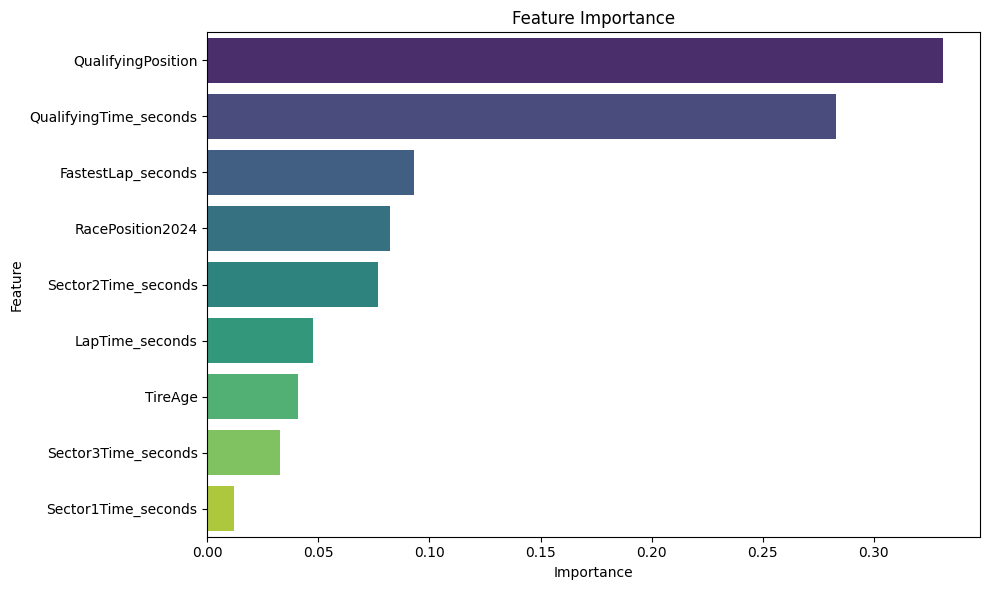

In [83]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<ipython-input-84-6ef5b2d55a76>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="BlendedPrediction", y="Driver", data=top10, palette="crest")


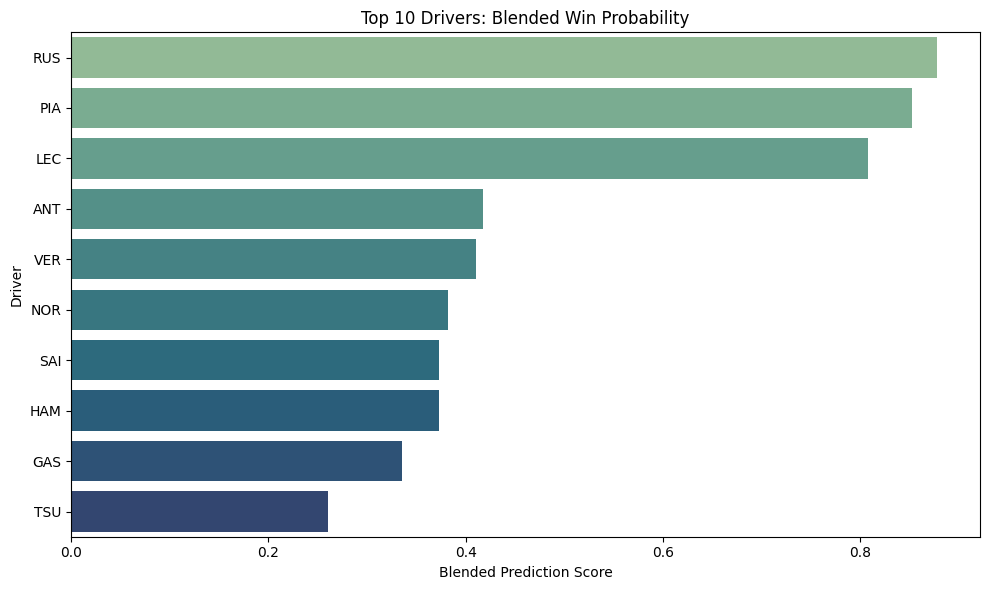

In [84]:
# Top 10 Drivers by Blended Prediction
top10 = winners.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="BlendedPrediction", y="Driver", data=top10, palette="crest")
plt.title("Top 10 Drivers: Blended Win Probability")
plt.xlabel("Blended Prediction Score")
plt.ylabel("Driver")
plt.tight_layout()
plt.show()

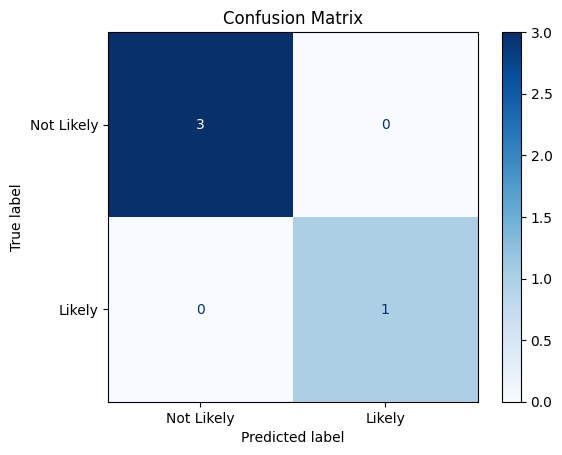

In [69]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Likely", "Likely"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()